## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns

In [16]:
data = [pd.read_csv('asos_snotel_UA_12hr_t1_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
asos_snotel_UA_df['LXV_WindSpeed_m/s']

asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps', 'LXV_WindSpeed_m/s_t1': 'LXV_WindSpeed_mps_t1'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
       'LXV_Temperature_degC', 'LXV_Dewpoint_degC',
       ...
       'KGJT_d500_400_speed_kts_t1', 'KGJT_d500_300_speed_kts_t1',
       'KGJT_d500_250_speed_kts_t1', 'KGJT_d500_200_speed_kts_t1',
       'KGJT_d400_300_speed_kts_t1', 'KGJT_d400_250_speed_kts_t1',
       'KGJT_d400_200_speed_kts_t1', 'KGJT_d300_250_speed_kts_t1',
       'KGJT_d300_200_speed_kts_t1', 'KGJT_d250_200_speed_kts_t1'],
      dtype='object', length=366)


In [8]:
print(asos_snotel_UA_df['CMtnSNTL_Temp_degC_t1'].describe())

count    7976.000000
mean        8.740602
std         6.683930
min         0.000000
25%         3.200000
50%         7.400000
75%        13.200000
max        35.100000
Name: CMtnSNTL_Temp_degC_t1, dtype: float64


### Create 12 hr snowfall dataframe by using 12hr snowdepth difference

In [17]:
import matplotlib.dates as mdates
#fig = plt.figure(figsize=(10,5))


#Calculate 12-snowfall column by finding difference between 12-hr snow depth observations 
asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'] = asos_snotel_UA_df['CMtnSNTL_SnowDepth_in']  #.resample('12H').first()
asos_snotel_UA_df['CMtnSNTL_12hr-dSNWD_in'] = asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in']-asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'].shift(+1)
asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in'] = asos_snotel_UA_df['CMtnSNTL_12hr-dSNWD_in']
asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_in'] = asos_snotel_UA_df['CMtnSNTL_12hr-dSNWD_in'].shift(-1)


asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'] = asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_in'][asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_in']>=3]
asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_gte3_in'] = asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in'][asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in']>=3]

shifted_df = pd.DataFrame()
shifted_df = asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'].shift(+12).copy()

#fig = plt.figure(figsize=(30,15))
#plt.subplot(2,1, 1)
#plt.subplots_adjust(hspace=0.5, wspace=0.2)




Let's verify that the 12hr snowfall is doing what we think it is

count    306.000000
mean       4.640098
std        2.189155
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       16.000000
Name: CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in, dtype: float64


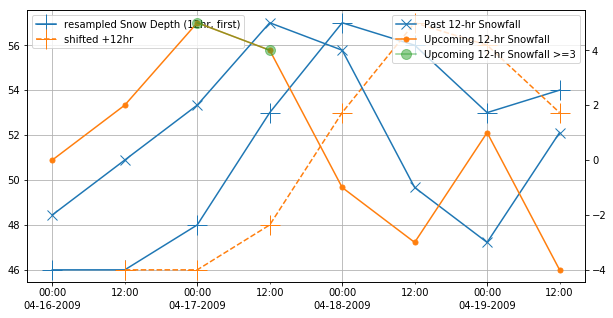

In [18]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
#ax1.plot(asos_snotel_UA_df['CMtnSNTL_SnowDepth_in']['04-16-2009':'04-19-2009'], marker='.', markersize = 10, label = "1hr Snow Depth")

ax1.plot(asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in']['04-16-2009':'04-19-2009'], marker='+', markersize = 20, label = "resampled Snow Depth (12hr, first)")
ax1.plot(asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in']['04-16-2009':'04-19-2009'].shift(+1), marker='+',linestyle='--', markersize = 20, label = "shifted +12hr")
ax2.plot(asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in']['04-16-2009':'04-19-2009'], marker='x', markersize = 10,  label = "Past 12-hr Snowfall")
ax2.plot(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_in']['04-16-2009':'04-19-2009'], marker='.', markersize = 10,  label = "Upcoming 12-hr Snowfall")
ax2.plot(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']['04-16-2009':'04-19-2009'], marker='.', markersize = 20, alpha = 0.5,  label = "Upcoming 12-hr Snowfall >=3")

#ax2 = asos_snotel_UA_df['CMtn_1hr_Precipitation_mm']['01-06-2009':'01-09-2009'].plot(marker='+', markersize = 10, secondary_y = True)

ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))  # hours and minutes
ax1.xaxis.set_major_formatter(mdates.DateFormatter('\n%m-%d-%Y')) 
#ax00.set_xlim(100, 12)

#plt.plot(shifted_df, linestyle = '-', linewidth = 10)
#print(shifted_df.describe)

#xlabel('Item (s)')
#ylabel('Value')
#title('Python Line Chart: Plotting numbers')

#plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')



#print(asos_snotel_df['12hr-dSNWD_in'].describe())
print(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].describe())


It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

In [19]:
asos_snotel_UA_df['LXV_12hr_delta_Pressure_hp'] = asos_snotel_UA_df['LXV_Pressure_hp']-asos_snotel_UA_df['LXV_Pressure_hp'].shift(+12)
print(asos_snotel_UA_df['LXV_12hr_delta_Pressure_hp'].describe())


count    7915.000000
mean       -0.032788
std        10.266949
min       -43.600000
25%        -6.000000
50%        -0.100000
75%         6.000000
max        41.900000
Name: LXV_12hr_delta_Pressure_hp, dtype: float64


***
# OLS Analysis of meteorological variables and snowfall (Training Dataset: 2008-2017 only)

**We will first utilize just the Copper Mountain surface level variables and run the model explicitly to generate statistics.  This will give snowfall predictive capability of individual meteorological variables (Dewpoint, SNOTEL Temperature, Temperature, Wind Speed, Cloud Cover, Wind Direction, 6hr Pressure change, and Pressure) using an OLS model and the 2008-2017 training dataset. The resulting values will also be used to verify some code which performs same analysis, but with a loop.  This code will then be fed all upper air and surface level variables to determine best combination of variables in the OLS model.**


In [20]:
#Import statsmodel

import statsmodels.api as sm
#import statsmodel
from statsmodels.formula.api import ols

### Single Variable OLS (CMtn Surface Variables)


In [ ]:


OLS_CMtn_Dewpoint = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_Dewpoint_degC',asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtnSNTL_Temp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtnSNTL_Temp_degC',asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_Temperature = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_Temperature_degC',asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_WindSpeed = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_WindSpeed_mps',asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_CloudCover = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_CloudCover_oktas', asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_WindDirection = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_WindDirection_deg', asos_snotel_UA_df['2008':'2017']).fit()
OLS_LXV_12hr_delta_Pressure = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ LXV_12hr_delta_Pressure_hp', asos_snotel_UA_df['2008':'2017']).fit()
OLS_LXV_Pressure = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ LXV_Pressure_hp', asos_snotel_UA_df['2008':'2017']).fit()


print(OLS_CMtn_Dewpoint.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtnSNTL_Temp.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_Temperature.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_WindSpeed.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_CloudCover.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_WindDirection.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_LXV_12hr_delta_Pressure.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_LXV_Pressure.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")



#['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
#       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
#       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
#       'LXV_Temperature_degC', 'LXV_Dewpoint_degC'


#print(a.rsquared)
#print(a.rsquared_adj)
#print(a.rsquared_adj)
#print(a.fvalue)
#print(a.f_pvalue)
#print(a.pvalues)
print(OLS_CMtn_Dewpoint.params)
#qq=sm.qqplot(a.resid, line='r')



#### Single Variable Summary
**Adjusted R:**  
OLS_CMtn_Dewpoint: 0.007  
OLS_CMtnSNTL_Temp:  -0.002 
OLS_CMtn_Temperature: -0.005  
OLS_CMtn_WindSpeed:  0.017  
OLS_CMtn_CloudCover:  0.000  
OLS_CMtn_WindDirection:  -0.004  
OLS_LXV_6hr_delta_Pressure:   0.004  
OLS_LXV_Pressure:    -0.003  

**Prob (F-statistic):**  
OLS_CMtn_Dewpoint: 0.139  
OLS_CMtnSNTL_Temp: 0.483  
OLS_CMtn_Temperature:  0.708  
OLS_CMtn_WindSpeed:  0.0466  
OLS_CMtn_CloudCover: 0.316 
OLS_CMtn_WindDirection:   0.614  
OLS_LXV_6hr_delta_Pressure:  0.155  
OLS_LXV_Pressure:   0.550 
  
From this, we can glean that Dewpoint alone likely has the best fit as the adjusted R squared is the highest.  The F statistics such signficant correlations (at 5% confident interval) for only  Dewpoint and Pressure).

## Run OLS model with all variables

In [ ]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts', \
  'CMtnSNTL_Temp_degC_t1', 'CMtn_Temperature_degC_t1', 'CMtn_Dewpoint_degC_t1', 'CMtn_WindDirection_deg_t1', 'CMtn_WindSpeed_mps_t1', 'CMtn_CloudCover_oktas_t1', \
 'LXV_Temperature_degC_t1', 'LXV_Dewpoint_degC_t1', 'LXV_Pressure_hp_t1', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m_t1', 'KGJT_200mb_tmpc_t1', 'KGJT_200mb_dwpc_t1', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m_t1', 'KGJT_250mb_tmpc_t1', 'KGJT_250mb_dwpc_t1', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m_t1', 'KGJT_300mb_tmpc_t1', 'KGJT_300mb_dwpc_t1', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m_t1', 'KGJT_400mb_tmpc_t1', 'KGJT_400mb_dwpc_t1', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m_t1', 'KGJT_500mb_tmpc_t1', 'KGJT_500mb_dwpc_t1', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m_t1', 'KGJT_700mb_tmpc_t1', 'KGJT_700mb_dwpc_t1', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m_t1', 'KGJT_850mb_tmpc_t1', 'KGJT_850mb_dwpc_t1', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts'] \

from collections import OrderedDict

variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:

        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, asos_snotel_UA_df['2008':'2017']).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, asos_snotel_UA_df['2008':'2017']).fit()
    
    print(max_var)
    #print(max_var)
    #print(OLS.rsquared)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)


In [ ]:
plt.plot(adjRs)

In [ ]:
plt.plot(f_pvalues)

## Determine which columns to use in OLS model.   
### Only going to to keep those data columns which have a matching hour to at least 67% of the snowfall measurements

In [34]:
print(asos_snotel_UA_df['CMtnSNTL_Temp_degC_t1'].describe())

#variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
# 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
# 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
# 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
# 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
# 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
# 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
# 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
# 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
# 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
# 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
# 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
# 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
# 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
# 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
# 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
# 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
# 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
# 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
# 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
# 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
# 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
# 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
# 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
# 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
# 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
# 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
# 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
# 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
# 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts', \
# 'CMtnSNTL_Temp_degC_t1', 'CMtn_Temperature_degC_t1', 'CMtn_Dewpoint_degC_t1', 'CMtn_WindDirection_deg_t1', 'CMtn_WindSpeed_mps_t1', 'CMtn_CloudCover_oktas_t1', \
# 'LXV_Temperature_degC_t1', 'LXV_Dewpoint_degC_t1', 'LXV_Pressure_hp_t1', 'LXV_WindSpeed_mps_t1', 'LXV_WindDirection_deg_t1', 'LXV_CloudCover_oktas_t1', \
# 'KGJT_200mb_height_m_t1', 'KGJT_200mb_tmpc_t1', 'KGJT_200mb_dwpc_t1', 'KGJT_200mb_drct_t1', 'KGJT_200mb_speed_kts_t1', \
# 'KGJT_250mb_height_m_t1', 'KGJT_250mb_tmpc_t1', 'KGJT_250mb_dwpc_t1', 'KGJT_250mb_drct_t1', 'KGJT_250mb_speed_kts_t1', \
# 'KGJT_300mb_height_m_t1', 'KGJT_300mb_tmpc_t1', 'KGJT_300mb_dwpc_t1', 'KGJT_300mb_drct_t1', 'KGJT_300mb_speed_kts_t1', \
# 'KGJT_400mb_height_m_t1', 'KGJT_400mb_tmpc_t1', 'KGJT_400mb_dwpc_t1', 'KGJT_400mb_drct_t1', 'KGJT_400mb_speed_kts_t1', \
# 'KGJT_500mb_height_m_t1', 'KGJT_500mb_tmpc_t1', 'KGJT_500mb_dwpc_t1', 'KGJT_500mb_drct_t1', 'KGJT_500mb_speed_kts_t1', \
# 'KGJT_700mb_height_m_t1', 'KGJT_700mb_tmpc_t1', 'KGJT_700mb_dwpc_t1', 'KGJT_700mb_drct_t1', 'KGJT_700mb_speed_kts_t1', \
# 'KGJT_850mb_height_m_t1', 'KGJT_850mb_tmpc_t1', 'KGJT_850mb_dwpc_t1', 'KGJT_850mb_drct_t1', 'KGJT_850mb_speed_kts_t1'] \



variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'CMtnSNTL_Temp_degC_t1', 'CMtn_Temperature_degC_t1', 'CMtn_Dewpoint_degC_t1', 'CMtn_WindDirection_deg_t1', 'CMtn_WindSpeed_mps_t1', 'CMtn_CloudCover_oktas_t1', \
 'LXV_Temperature_degC_t1', 'LXV_Dewpoint_degC_t1', 'LXV_Pressure_hp_t1', 'LXV_WindSpeed_mps_t1', 'LXV_WindDirection_deg_t1', 'LXV_CloudCover_oktas_t1']

good_vars = []
bad_vars = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df['2008':'2017'][var])
    total_poss = len(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df['2008':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    total_avail =len(asos_snotel_UA_df['2008':'2017'][idx])
    if total_avail/total_poss >= 0.67: 
        good_vars.append(var)
    else:
        bad_vars.append(var)
        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars)
    
    
    


count    7976.000000
mean        8.740602
std         6.683930
min         0.000000
25%         3.200000
50%         7.400000
75%        13.200000
max        35.100000
Name: CMtnSNTL_Temp_degC_t1, dtype: float64
Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'CMtnSNTL_Temp_degC_t1', 'CMtn_Temperature_degC_t1', 'CMtn_Dewpoint_degC_t1', 'CMtn_WindDirection_deg_t1', 'CMtn_WindSpeed_mps_t1', 'LXV_Temperature_degC_t1', 'LXV_Dewpoint_degC_t1', 'LXV_Pressure_hp_t1', 'LXV_WindSpeed_mps_t1', 'LXV_WindDirection_deg_t1']
Variables with < 67% data match to snowfall: 
['CMtn_CloudCover_oktas', 'LXV_CloudCover_oktas', 'CMtn_CloudCover_oktas_t1', 'LXV_CloudCover_oktas_t1']


**Perform OLS just on "bad" variables"**

In [ ]:
from collections import OrderedDict

variables = bad_vars
variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:
        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, asos_snotel_UA_df['2008':'2017']).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, asos_snotel_UA_df['2008':'2017']).fit()
    #print(max_var)
    #print(OLS.rsquared)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)



In [ ]:
plt.plot(adjRs)
print(adjRs)

In [ ]:
plt.plot(f_pvalues)
print(f_pvalues)

There is some odd behavior here.  Research showed that the high adj R values are due to many missing variable matches to snowfall values, resulting in fictious good fits.  Let's try fitting the model using just the variables with data capture >67%.

### Now run OLS model with the chosen variables ##

In [35]:
from collections import OrderedDict

variables = good_vars
variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:
        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, asos_snotel_UA_df['2008':'2017']).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, asos_snotel_UA_df['2008':'2017']).fit()
    print(max_var)
    print(OLS.rsquared_adj)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)



['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'CMtnSNTL_Temp_degC_t1', 'CMtn_Temperature_degC_t1', 'CMtn_Dewpoint_degC_t1', 'CMtn_WindDirection_deg_t1', 'CMtn_WindSpeed_mps_t1', 'LXV_Temperature_degC_t1', 'LXV_Dewpoint_degC_t1', 'LXV_Pressure_hp_t1', 'LXV_WindSpeed_mps_t1', 'LXV_WindDirection_deg_t1']
******
CMtn_WindSpeed_mps
0.015222793460097694
CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps
0.04323637698186733
LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps
0.040684745379387155
CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps
0.03805271870770355
LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps
0.04300701634146631
LXV_WindDirection_deg+ LXV_Temperature_degC+ CMtn

ValueError: max() arg is an empty sequence

**Create plot of adjusted R squared**

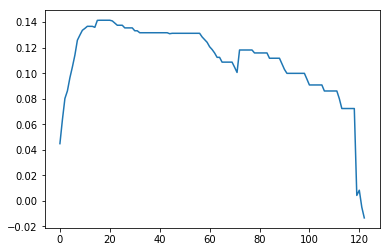

In [24]:
plt.plot(adjRs)

**Create plot of probabilities associated with the F statistic**

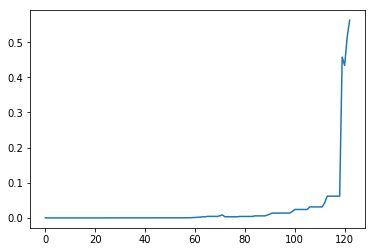

In [25]:
plt.plot(f_pvalues)

**Print adjusted R and F stat probabilities in order**

In [28]:
stats = list(zip(adjRs, f_pvalues))
dictionary = OrderedDict(zip(max_vars, stats))
for c in dictionary:
    #print(str(dictionary.keys().index(c))+"{country}: {capital}".format(country=c, capital=dictionary[c])+"\n")
        print(str(list(dictionary.keys()).index(c))+ " {key} \n Adjusted R: {adjR}  Fstat(prob): {f_pvalue}".format(key=c, adjR=dictionary[c][0], f_pvalue = dictionary[c][1])+"\n")
        OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + c, asos_snotel_UA_df['2008':'2017']).fit()



0 KGJT_500mb_speed_kts_t1 
 Adjusted R: 0.044866552445929075  Fstat(prob): 0.00045018120923450165

1 LXV_Dewpoint_degC+ KGJT_500mb_speed_kts_t1 
 Adjusted R: 0.0636221404918339  Fstat(prob): 0.00011374994634728606

2 KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts_t1 
 Adjusted R: 0.0802177040222194  Fstat(prob): 3.1525696505670414e-05

3 KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts_t1 
 Adjusted R: 0.08615054701675617  Fstat(prob): 3.4979934382544555e-05

4 KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts_t1 
 Adjusted R: 0.09646351845236045  Fstat(prob): 1.8709044458102378e-05

5 KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts_t1 
 Adjusted R: 0.10491931170229218  Fstat(prob): 1.2058075829322078e-05

6 KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewp

28 KGJT_d500_200_dwpc+ KGJT_200mb_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc_t1+ KGJT_d500_250_dwpc+ KGJT_d700_200_speed_kts+ LXV_WindDirection_deg_t1+ KGJT_d850_400_height_m+ KGJT_d700_400_height_m+ KGJT_500mb_dwpc+ KGJT_d700_500_height_m+ KGJT_700mb_dwpc+ KGJT_d850_500_height_m+ KGJT_500mb_tmpc_t1+ KGJT_d300_250_drct+ KGJT_d500_300_drct+ KGJT_700mb_tmpc_t1+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts_t1 
 Adjusted R: 0.13551110266274313  Fstat(prob): 9.675478403329409e-05

29 KGJT_d250_200_dwpc+ KGJT_d500_200_dwpc+ KGJT_200mb_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc_t1+ KGJT_d500_250_dwpc+ KGJT_d700_200_speed_kts+ LXV_WindDirection_deg_t1+ KGJT_d850_400_height_m+ KGJT_d700_400_height_m+ KGJT_500mb_dwpc+ KGJT_d700_500_height_m+ KGJT_700mb_dwpc+ KGJT_d850_500_height

40 KGJT_d400_300_height_m+ KGJT_400mb_height_m_t1+ KGJT_500mb_height_m_t1+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d700_300_height_m+ KGJT_850mb_height_m_t1+ KGJT_700mb_height_m_t1+ KGJT_d500_300_height_m+ KGJT_d300_250_height_m+ KGJT_250mb_height_m+ KGJT_d250_200_dwpc+ KGJT_d500_200_dwpc+ KGJT_200mb_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc_t1+ KGJT_d500_250_dwpc+ KGJT_d700_200_speed_kts+ LXV_WindDirection_deg_t1+ KGJT_d850_400_height_m+ KGJT_d700_400_height_m+ KGJT_500mb_dwpc+ KGJT_d700_500_height_m+ KGJT_700mb_dwpc+ KGJT_d850_500_height_m+ KGJT_500mb_tmpc_t1+ KGJT_d300_250_drct+ KGJT_d500_300_drct+ KGJT_700mb_tmpc_t1+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts_t1 
 Adjusted R: 0.1317155786979357  Fstat(prob): 0.0002032154376727638

41 KGJT_d500_250_height_m+ KGJT_d400_

49 KGJT_200mb_height_m_t1+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_250_tmpc+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m_t1+ KGJT_500mb_height_m_t1+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d700_300_height_m+ KGJT_850mb_height_m_t1+ KGJT_700mb_height_m_t1+ KGJT_d500_300_height_m+ KGJT_d300_250_height_m+ KGJT_250mb_height_m+ KGJT_d250_200_dwpc+ KGJT_d500_200_dwpc+ KGJT_200mb_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc_t1+ KGJT_d500_250_dwpc+ KGJT_d700_200_speed_kts+ LXV_WindDirection_deg_t1+ KGJT_d850_400_height_m+ KGJT_d700_400_height_m+ KGJT_500mb_dwpc+ KGJT_d700_500_height_m+ KGJT_700mb_dwpc+ KGJT_d850_500_height_m+ KGJT_500mb_tmpc_t1+ KGJT_d300_250_drct+ KGJT_d500_300_drct+ KGJT_700mb_tmpc_t1+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tm


57 LXV_Temperature_degC_t1+ KGJT_d500_200_height_m+ KGJT_d250_200_height_m+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_200_height_m+ KGJT_200mb_height_m_t1+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_250_tmpc+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m_t1+ KGJT_500mb_height_m_t1+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d700_300_height_m+ KGJT_850mb_height_m_t1+ KGJT_700mb_height_m_t1+ KGJT_d500_300_height_m+ KGJT_d300_250_height_m+ KGJT_250mb_height_m+ KGJT_d250_200_dwpc+ KGJT_d500_200_dwpc+ KGJT_200mb_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc_t1+ KGJT_d500_250_dwpc+ KGJT_d700_200_speed_kts+ LXV_WindDirection_deg_t1+ KGJT_d850_400_height_m+ KGJT_d700_400_height_m+ KGJT_500mb_dwpc+ KGJT_d700_500_height_m+ KGJT_700mb_dwpc+ KGJT_d850_500_height_m+ KGJT_500mb_tmpc_t1+ KGJT_d300_250_drct


63 KGJT_d700_400_speed_kts+ KGJT_250mb_drct_t1+ KGJT_d400_200_drct+ KGJT_500mb_drct_t1+ LXV_Pressure_hp+ KGJT_300mb_drct_t1+ LXV_Temperature_degC_t1+ KGJT_d500_200_height_m+ KGJT_d250_200_height_m+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_200_height_m+ KGJT_200mb_height_m_t1+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_250_tmpc+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m_t1+ KGJT_500mb_height_m_t1+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d700_300_height_m+ KGJT_850mb_height_m_t1+ KGJT_700mb_height_m_t1+ KGJT_d500_300_height_m+ KGJT_d300_250_height_m+ KGJT_250mb_height_m+ KGJT_d250_200_dwpc+ KGJT_d500_200_dwpc+ KGJT_200mb_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc_t1+ KGJT_d500_250_dwpc+ KGJT_d700_200_speed_kts+ LXV_WindDirection_deg_t1+ KGJT_d850_400_height_m+ KGJT_d700_400_height_m

70 KGJT_d500_300_speed_kts+ KGJT_d400_200_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_250mb_drct_t1+ KGJT_d400_200_drct+ KGJT_500mb_drct_t1+ LXV_Pressure_hp+ KGJT_300mb_drct_t1+ LXV_Temperature_degC_t1+ KGJT_d500_200_height_m+ KGJT_d250_200_height_m+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_200_height_m+ KGJT_200mb_height_m_t1+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_250_tmpc+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m_t1+ KGJT_500mb_height_m_t1+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d700_300_height_m+ KGJT_850mb_height_m_t1+ KGJT_700mb_height_m_t1+ KGJT_d500_300_height_m+ KGJT_d300_250_height_m+ KGJT_250mb_height_m+ KGJT_d250_200_dwpc+ KGJT_d500_200_dwpc+ KGJT_200mb_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_2

76 KGJT_d500_400_drct+ KGJT_d300_200_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d500_200_drct+ KGJT_200mb_drct_t1+ KGJT_d500_300_speed_kts+ KGJT_d400_200_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_250mb_drct_t1+ KGJT_d400_200_drct+ KGJT_500mb_drct_t1+ LXV_Pressure_hp+ KGJT_300mb_drct_t1+ LXV_Temperature_degC_t1+ KGJT_d500_200_height_m+ KGJT_d250_200_height_m+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_200_height_m+ KGJT_200mb_height_m_t1+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_250_tmpc+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m_t1+ KGJT_500mb_height_m_t1+ KGJT_d700_250_height_m+ KGJT_d400_250_height_m+ KGJT_d700_300_height_m+ KGJT_850mb_height_m_t1+ KGJT_700mb_height_m_t1+ KGJT_d500_300_height_m+ KGJT_d300_250

82 KGJT_d700_300_drct+ KGJT_d700_200_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_d700_500_drct+ KGJT_d250_200_drct+ KGJT_d500_400_drct+ KGJT_d300_200_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d500_200_drct+ KGJT_200mb_drct_t1+ KGJT_d500_300_speed_kts+ KGJT_d400_200_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_250mb_drct_t1+ KGJT_d400_200_drct+ KGJT_500mb_drct_t1+ LXV_Pressure_hp+ KGJT_300mb_drct_t1+ LXV_Temperature_degC_t1+ KGJT_d500_200_height_m+ KGJT_d250_200_height_m+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_200_height_m+ KGJT_200mb_height_m_t1+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_250_tmpc+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m_t1+ KGJT_500mb_height_m_t1+ KGJT_d700_250_height_m+ KGJT_d400_250

88 KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_400mb_drct+ KGJT_d700_300_drct+ KGJT_d700_200_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_d700_500_drct+ KGJT_d250_200_drct+ KGJT_d500_400_drct+ KGJT_d300_200_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d500_200_drct+ KGJT_200mb_drct_t1+ KGJT_d500_300_speed_kts+ KGJT_d400_200_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_250mb_drct_t1+ KGJT_d400_200_drct+ KGJT_500mb_drct_t1+ LXV_Pressure_hp+ KGJT_300mb_drct_t1+ LXV_Temperature_degC_t1+ KGJT_d500_200_height_m+ KGJT_d250_200_height_m+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_200_height_m+ KGJT_200mb_height_m_t1+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_250_tmpc+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d500_250_heigh

94 KGJT_400mb_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts_t1+ KGJT_700mb_speed_kts_t1+ CMtnSNTL_Temp_degC_t1+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_400mb_drct+ KGJT_d700_300_drct+ KGJT_d700_200_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_d700_500_drct+ KGJT_d250_200_drct+ KGJT_d500_400_drct+ KGJT_d300_200_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d500_200_drct+ KGJT_200mb_drct_t1+ KGJT_d500_300_speed_kts+ KGJT_d400_200_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_250mb_drct_t1+ KGJT_d400_200_drct+ KGJT_500mb_drct_t1+ LXV_Pressure_hp+ KGJT_300mb_drct_t1+ LXV_Temperature_degC_t1+ KGJT_d500_200_height_m+ KGJT_d250_200_height_m+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_200_height_m+ KGJT_200mb_height_m_t1+ KGJT_200mb_tmpc+ KGJ

98 KGJT_d700_300_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts_t1+ KGJT_700mb_speed_kts_t1+ CMtnSNTL_Temp_degC_t1+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_400mb_drct+ KGJT_d700_300_drct+ KGJT_d700_200_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_d700_500_drct+ KGJT_d250_200_drct+ KGJT_d500_400_drct+ KGJT_d300_200_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d500_200_drct+ KGJT_200mb_drct_t1+ KGJT_d500_300_speed_kts+ KGJT_d400_200_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_250mb_drct_t1+ KGJT_d400_200_drct+ KGJT_500mb_drct_t1+ LXV_Pressure_hp+ KGJT_300mb_drct_t1+ LXV_Temperature_degC_t1+ KGJT_d500_200_height_m+ KGJT_d250_200_height_m+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d70

102 KGJT_d500_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d400_250_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_300_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts_t1+ KGJT_700mb_speed_kts_t1+ CMtnSNTL_Temp_degC_t1+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_400mb_drct+ KGJT_d700_300_drct+ KGJT_d700_200_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_d700_500_drct+ KGJT_d250_200_drct+ KGJT_d500_400_drct+ KGJT_d300_200_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d500_200_drct+ KGJT_200mb_drct_t1+ KGJT_d500_300_speed_kts+ KGJT_d400_200_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_250mb_drct_t1+ KGJT_d400_200_drct+ KGJT_500mb_drct_t1+ LXV_Pressure_hp+ KGJT_300mb_drct_t1+ LXV_Temperature_degC_t1+ KGJT_d500_20

106 KGJT_d700_300_tmpc+ KGJT_d300_250_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d400_250_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_300_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts_t1+ KGJT_700mb_speed_kts_t1+ CMtnSNTL_Temp_degC_t1+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_400mb_drct+ KGJT_d700_300_drct+ KGJT_d700_200_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_d700_500_drct+ KGJT_d250_200_drct+ KGJT_d500_400_drct+ KGJT_d300_200_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d500_200_drct+ KGJT_200mb_drct_t1+ KGJT_d500_300_speed_kts+ KGJT_d400_200_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_250mb_drct_t1+ KGJT_d400_200_drct+

110 KGJT_d500_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_250_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d400_250_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_300_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts_t1+ KGJT_700mb_speed_kts_t1+ CMtnSNTL_Temp_degC_t1+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_400mb_drct+ KGJT_d700_300_drct+ KGJT_d700_200_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_d700_500_drct+ KGJT_d250_200_drct+ KGJT_d500_400_drct+ KGJT_d300_200_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d500_200_drct+ KGJT_200mb_drct_t1+ KGJT_d500_300_speed_kts+ KGJT_d400_200_dwpc+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_20

114 KGJT_d400_300_dwpc+ KGJT_d300_250_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d300_250_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_250_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d400_250_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_300_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts_t1+ KGJT_700mb_speed_kts_t1+ CMtnSNTL_Temp_degC_t1+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_400mb_drct+ KGJT_d700_300_drct+ KGJT_d700_200_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_d700_500_drct+ KGJT_d250_200_drct+ KGJT_d500_400_drct+ KGJT_d300_200_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d500_200_drct+ KGJT_200mb_drct_t1+ KGJT_d500_300_speed_kts+ KGJT_d400_200_dwpc+ K

118 KGJT_d500_300_dwpc+ KGJT_300mb_dwpc_t1+ KGJT_d700_300_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_300_dwpc+ KGJT_d300_250_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d300_250_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_250_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d400_250_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_300_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts_t1+ KGJT_700mb_speed_kts_t1+ CMtnSNTL_Temp_degC_t1+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_tmpc+ KGJT_d700_400_tmpc+ KGJT_400mb_tmpc+ KGJT_400mb_drct+ KGJT_d700_300_drct+ KGJT_d700_200_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_d700_500_drct+ KGJT_d250_200_drct+ KGJT_d500_400_drct+ KGJT_d300_200_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d

**Find max adj R and obtain OLS summary**

In [29]:
 # Just use 'min' instead of 'max' for minimum.
print("Print maximum:")
maximum = max(dictionary, key=dictionary.get) 
print(maximum)

Print maximum:
KGJT_700mb_dwpc+ KGJT_d850_500_height_m+ KGJT_500mb_tmpc_t1+ KGJT_d300_250_drct+ KGJT_d500_300_drct+ KGJT_700mb_tmpc_t1+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts_t1


In [30]:
maximum_all_str = max(dictionary, key=dictionary.get) 
print(maximum_all_str)

maxOLS_all = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + maximum_all_str , asos_snotel_UA_df['2008':'2017']).fit() 
print(maxOLS_all.summary())


KGJT_700mb_dwpc+ KGJT_d850_500_height_m+ KGJT_500mb_tmpc_t1+ KGJT_d300_250_drct+ KGJT_d500_300_drct+ KGJT_700mb_tmpc_t1+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts_t1
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.198
Model:                                               OLS   Adj. R-squared:                  0.142
Method:                                    Least Squares   F-statistic:                     3.503
Date:                                   Wed, 23 Jan 2019   Prob (F-statistic):           1.27e-05
Time:                                           14:41:02   Log-Likelihood:                -523.43
No. Observations:                                    244   A

**Print QQ plot**

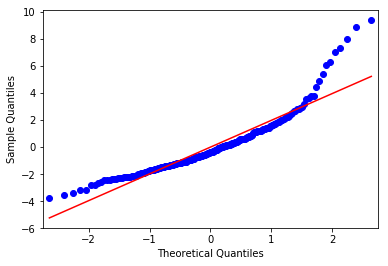

In [31]:
qq2=sm.qqplot(maxOLS_all.resid, line='r')

**There are a few variables with P|t| values which are high, noteably the KGJT_d500_300_speed_kts variable with P|t| of 0.9, indicative of high randomness. Let's test different P|t| thresholds for which to remove variables, rerun and model for each set of variables, and see what threshold might glean best results**

In [32]:
rsq_adj = 0
thresh = 0

goodp_str = ""
highp_var = []

maximum_all_str = max(dictionary, key=dictionary.get)    #this is the string of variables found in previous OLS run associated with mad adjusted R squared.
print(maximum_all_str)


for test_thresh in range(1, 100):   #loop through different P|t| thresholds ranging from 1 to 100.  Note floats are not allowed here 
  print(test_thresh)
  highp_var = [var for var in maxOLS_all.pvalues.keys() if maxOLS_all.pvalues[var]>=test_thresh*0.01]  #check P|t| for each variable against threshold and store in list
  
  testgoodp_str = maximum_all_str   #reset testgoodp_str 
    
  for var in highp_var:
    testgoodp_str = testgoodp_str.replace("+ " + var, "")   #  
     

 

  maxOLS_testgoodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + testgoodp_str, asos_snotel_UA_df['2008':'2017']).fit()
  print(testgoodp_str, maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
  #print(maxOLS_testgoodp.rsquared_adj)
  if maxOLS_testgoodp.rsquared_adj > rsq_adj:
      rsq_adj = maxOLS_testgoodp.rsquared_adj
      print(maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
      goodp_str = testgoodp_str
      thresh = test_thresh*0.01

    
print("\n best threshold is:" + str(thresh))
maxOLS_goodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + goodp_str, asos_snotel_UA_df['2008':'2017']).fit() 
print(maxOLS_goodp.summary())


KGJT_700mb_dwpc+ KGJT_d850_500_height_m+ KGJT_500mb_tmpc_t1+ KGJT_d300_250_drct+ KGJT_d500_300_drct+ KGJT_700mb_tmpc_t1+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts_t1
1
KGJT_700mb_dwpc+ KGJT_d500_250_drct 0.013888421505632964 0.01
0.013888421505632964 0.01
2
KGJT_700mb_dwpc+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ LXV_Dewpoint_degC 0.07865506058605731 0.02
0.07865506058605731 0.02
3
KGJT_700mb_dwpc+ KGJT_d850_700_height_m+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ LXV_Dewpoint_degC 0.10218819250314104 0.03
0.10218819250314104 0.03
4
KGJT_700mb_dwpc+ KGJT_d850_700_height_m+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ LXV_Dewpoint_degC 0.10218819250314104 0.04
5
KGJT_700mb_dwpc+ KGJT_d850_70

KGJT_700mb_dwpc+ KGJT_d850_500_height_m+ KGJT_500mb_tmpc_t1+ KGJT_d300_250_drct+ KGJT_700mb_tmpc_t1+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC 0.13945647440471132 0.32
33
KGJT_700mb_dwpc+ KGJT_d850_500_height_m+ KGJT_500mb_tmpc_t1+ KGJT_d300_250_drct+ KGJT_700mb_tmpc_t1+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC 0.13945647440471132 0.33
34
KGJT_700mb_dwpc+ KGJT_d850_500_height_m+ KGJT_500mb_tmpc_t1+ KGJT_d300_250_drct+ KGJT_700mb_tmpc_t1+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC 0.13945647440471132 0.34
35
KGJT_700mb_dwpc+ KGJT_d850_500_height_m+ KGJT_500mb_tmp

KGJT_700mb_dwpc+ KGJT_d850_500_height_m+ KGJT_500mb_tmpc_t1+ KGJT_d300_250_drct+ KGJT_d500_300_drct+ KGJT_700mb_tmpc_t1+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts_t1 0.137106039844331 0.61
62
KGJT_700mb_dwpc+ KGJT_d850_500_height_m+ KGJT_500mb_tmpc_t1+ KGJT_d300_250_drct+ KGJT_d500_300_drct+ KGJT_700mb_tmpc_t1+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts_t1 0.137106039844331 0.62
63
KGJT_700mb_dwpc+ KGJT_d850_500_height_m+ KGJT_500mb_tmpc_t1+ KGJT_d300_250_drct+ KGJT_d500_300_drct+ KGJT_700mb_tmpc_t1+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_t

KGJT_700mb_dwpc+ KGJT_d850_500_height_m+ KGJT_500mb_tmpc_t1+ KGJT_d300_250_drct+ KGJT_d500_300_drct+ KGJT_700mb_tmpc_t1+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts_t1 0.137106039844331 0.86
87
KGJT_700mb_dwpc+ KGJT_d850_500_height_m+ KGJT_500mb_tmpc_t1+ KGJT_d300_250_drct+ KGJT_d500_300_drct+ KGJT_700mb_tmpc_t1+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts_t1 0.14150011842863008 0.87
0.14150011842863008 0.87
88
KGJT_700mb_dwpc+ KGJT_d850_500_height_m+ KGJT_500mb_tmpc_t1+ KGJT_d300_250_drct+ KGJT_d500_300_drct+ KGJT_700mb_tmpc_t1+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_40

**So it looks like the best P|t| threshold for variable elimination is 0.25.  By doing, this the adjusted R squared only increased slightly to 0.14**

## Try fit parameters with test dataset (2006 and 2007 data)

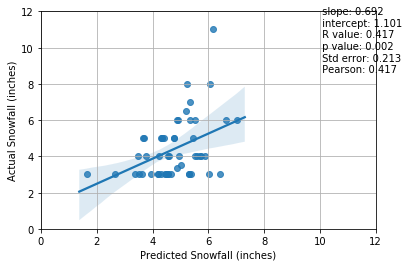

In [33]:

from scipy.stats import pearsonr, linregress
#print(asos_snotel_UA_df['2006':'2007'][asos_snotel_UA_df['2006':'2007']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3].describe())

actual_snf = asos_snotel_UA_df['2006':'2007']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df['2006':'2007']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3]
predict = maxOLS_goodp.predict(asos_snotel_UA_df['2006':'2007'][asos_snotel_UA_df['2006':'2007']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3])
#print(actual_snf.describe())


idx = np.isfinite(predict) & np.isfinite(actual_snf) 
sns.regplot(predict[idx], actual_snf[idx])

#print(asos_snotel_UA_df['2006':'2007'][asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in']>=3].describe())

slope1, intercept1, r_value1, p_value1, std_err1 = linregress(predict[idx], actual_snf[idx])
pearson1, pv = pearsonr(predict[idx], actual_snf[idx])
plt.annotate(' slope: ' + str(round(slope1,3)) +
                 '\n intercept: ' + str(round(intercept1,3)) + 
                 '\n R value: ' + str(round(r_value1,3)) +  
                 '\n p value: ' + str(round(p_value1,3)) + 
                 '\n Std error: ' + str(round(std_err1,3)) +
                 '\n Pearson: ' + str(round(pearson1,3)), \
                 xy=(0.83, 0.72), xycoords='axes fraction', fontsize=10)

plt.xlabel('Predicted Snowfall (inches)')
plt.ylabel('Actual Snowfall (inches)')
plt.xlim([0,12])
plt.ylim([0,12])
plt.grid(True)
#print(actual_snf.describe())
#print(predict.describe())

Note the lowest possible value in the actual snowfall data is 3 inches.  It looks like the lowest predicted snowfall is only 1 inch.  Let's just add 2 inches of snow across the board to the predicted values and see how this impacts

In [ ]:

predict = maxOLS_goodp.predict(asos_snotel_UA_df['2006':'2007'][asos_snotel_UA_df['2006':'2007']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3])+2
#print(actual_snf.describe())


idx = np.isfinite(predict) & np.isfinite(actual_snf) 
sns.regplot(predict[idx], actual_snf[idx])

#print(asos_snotel_UA_df['2006':'2007'][asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in']>=3].describe())

slope1, intercept1, r_value1, p_value1, std_err1 = linregress(predict[idx], actual_snf[idx])
pearson1, pv = pearsonr(predict[idx], actual_snf[idx])
plt.annotate(' slope: ' + str(round(slope1,3)) +
                 '\n intercept: ' + str(round(intercept1,3)) + 
                 '\n R value: ' + str(round(r_value1,3)) +  
                 '\n p value: ' + str(round(p_value1,3)) + 
                 '\n Std error: ' + str(round(std_err1,3)) +
                 '\n Pearson: ' + str(round(pearson1,3)), \
                 xy=(0.83, 0.72), xycoords='axes fraction', fontsize=10)

plt.xlabel('Predicted Snowfall (inches)')
plt.ylabel('Actual Snowfall (inches)')
plt.xlim([0,12])
plt.ylim([0,12])
plt.grid(True)
#print(actual_snf.describe())
#print(predict.describe())

**Let's try this without wind direction variables**

In [ ]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc',  'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc',  'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc',  'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc',  'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc',  'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc',  'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc',  'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc',  'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc',  'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc',  'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc',  'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc',  'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc',  'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc',  'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc',  'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc',  'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc',  'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc',  'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc',  'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc',  'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc',  'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc',  'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc',  'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc',  'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc',  'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc',  'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',  'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',  'KGJT_d250_200_speed_kts']

good_vars = []
bad_vars = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df['2008':'2017'][var])
    total_poss = len(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df['2008':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    total_avail =len(asos_snotel_UA_df['2008':'2017'][idx])
    if total_avail/total_poss >= 0.67: 
        good_vars.append(var)
    else:
        bad_vars.append(var)
        
print('Variables with >= 75% data match to snowfall: ')
print(good_vars)
print('Variables with < 75% data match to snowfall: ')
print(bad_vars)

In [ ]:
from collections import OrderedDict

variables = good_vars
variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:
        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, asos_snotel_UA_df['2008':'2017']).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, asos_snotel_UA_df['2008':'2017']).fit()
    print(max_var)
    print(OLS.rsquared_adj)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)


In [ ]:
plt.plot(adjRs)

In [ ]:
maximum = max(dictionary, key=dictionary.get) 
print(maximum)

maxOLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + maximum , asos_snotel_UA_df['2008':'2017']).fit() 
print(maxOLS.summary())
qq2=sm.qqplot(maxOLS.resid, line='r')